### What is the relationship between the average price of gasoline and the cost of electricity per kilowatt-hour, what model(s) can be used to make accurate predictions of future gas prices?

### Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load datasets
gasoline_data_path = 'gasoline_data.csv'
electric_data_path = 'electric_data.csv'

gasoline_data = pd.read_csv(gasoline_data_path)
electric_data = pd.read_csv(electric_data_path)

### Data Cleansing

In [ ]:
# split into proper columns
gasoline_data_clean = gasoline_data['series_id        \tyear\tperiod\t       value\tfootnote_codes'].str.split('\t', expand=True)
electric_data_clean = electric_data['series_id        \tyear\tperiod\t       value\tfootnote_codes'].str.split('\t', expand=True)

# rename columns
gasoline_columns = ['Series ID', 'Year', 'Period', 'Gasoline Price', 'Footnote Codes']
electric_columns = ['Series ID', 'Year', 'Period', 'Electricity Price', 'Footnote Codes']

gasoline_data_clean.columns = gasoline_columns
electric_data_clean.columns = electric_columns

# remove whitespace
gasoline_data_clean = gasoline_data_clean.apply(lambda x: x.str.strip())
electric_data_clean = electric_data_clean.apply(lambda x: x.str.strip())

# handle '-' entries
gasoline_data_clean['Gasoline Price'] = pd.to_numeric(gasoline_data_clean['Gasoline Price'], errors='coerce')
electric_data_clean['Electricity Price'] = pd.to_numeric(electric_data_clean['Electricity Price'], errors='coerce')

# check missing values
gasoline_missing = gasoline_data_clean.isnull().sum()
electric_missing = electric_data_clean.isnull().sum()

# display count of missing values (0 means none)
gasoline_missing, electric_missing

### Exploratory Analysis

In [ ]:
# basic stats for both datasets
gasoline_stats = gasoline_data_clean.describe()
electric_stats = electric_data_clean.describe()

# period to months
gasoline_data_clean['Month'] = gasoline_data_clean['Period'].str.replace('M', '').astype(int)
electric_data_clean['Month'] = electric_data_clean['Period'].str.replace('M', '').astype(int)
gasoline_data_clean['Date'] = pd.to_datetime(gasoline_data_clean[['Year', 'Month']].assign(DAY=1))
electric_data_clean['Date'] = pd.to_datetime(electric_data_clean[['Year', 'Month']].assign(DAY=1))

# Since the granularity is monthly, we'll average monthly prices for a direct comparison
gasoline_monthly_avg = gasoline_data_clean.groupby('Date')['Gasoline Price'].mean().reset_index()
electric_monthly_avg = electric_data_clean.groupby('Date')['Electricity Price'].mean().reset_index()

# merge
merged_data = pd.merge(gasoline_monthly_avg, electric_monthly_avg, on='Date', how='inner')

# plot
plt.figure(figsize=(14, 7))
plt.plot(merged_data['Date'], merged_data['Gasoline Price'], label='Gasoline Price ($/gallon)', color='blue')
plt.plot(merged_data['Date'], merged_data['Electricity Price'], label='Electricity Price ($/kWh)', color='green')
plt.title('Monthly Average Gasoline and Electricity Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

gasoline_stats, electric_stats

### Working with straightforward data (time and price), dimensionality reduction might not add value. More well-suited for datasets with large amounts of features

### Going to need more features for a more robust model. Adding some more features: (WTI Crude Oil Historical Data, 

In [ ]:
# processing crude oil data for merged_data
wti_data = pd.read_csv('wti-crudeoil.csv', names=['Date', 'WTI Oil Price'], header=0)
wti_data['Date'] = pd.to_datetime(wti_data['Date'])
wti_data['Year'] = wti_data['Date'].dt.year
wti_data['Month'] = wti_data['Date'].dt.month
wti_monthly_avg = wti_data.groupby(['Year', 'Month'])['WTI Oil Price'].mean().reset_index()
wti_monthly_avg['Date'] = pd.to_datetime(wti_monthly_avg[['Year', 'Month']].assign(Day=1))
wti_monthly_avg = wti_monthly_avg[['Date', 'WTI Oil Price']]
merged_data = pd.merge(merged_data, wti_monthly_avg, on='Date', how='left')

# processing unemployment data for merged_data
unemployment_data = pd.read_csv('unemployment.csv', names=['Date', 'Unemployment Rate'], header=0)
unemployment_data['Date'] = pd.to_datetime(unemployment_data['Date'])
unemployment_data['Year'] = unemployment_data['Date'].dt.year
unemployment_data['Month'] = unemployment_data['Date'].dt.month
unemployment_data['Date'] = pd.to_datetime(unemployment_data[['Year', 'Month']].assign(Day=1))
unemployment_data = unemployment_data[['Date', 'Unemployment Rate']]
merged_data = pd.merge(merged_data, unemployment_data, on='Date', how='left')

# Check for missing values
print(merged_data.isnull().sum())

# Impute missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

X = merged_data[['Electricity Price', 'WTI Oil Price', 'Unemployment Rate']]
X_imputed = imputer.fit_transform(X)

X = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

y = merged_data['Gasoline Price']

# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)

# Fit a linear regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

# Examine model coefficients
coef_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coef_df)

## Linear Regression Model

In [ ]:
# Fit a linear regression model
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

y_pred = lr_model.predict(X_test_scaled)

# Evaluate the linear regression model
lr_y_pred = lr_model.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_y_pred)

print("Linear Regression Model:")
print(f"Root Mean Squared Error: {lr_rmse:.2f}")
print(f"R-squared: {lr_r2:.2f}")

## K-Nearest Neighbors Model

In [ ]:
# Fit a KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# Evaluate the KNN model
knn_y_pred = knn_model.predict(X_test_scaled)

knn_mse = mean_squared_error(y_test, knn_y_pred)
knn_rmse = np.sqrt(knn_mse)
knn_r2 = r2_score(y_test, knn_y_pred)

print("\nKNN Model:")
print(f"Root Mean Squared Error: {knn_rmse:.2f}")
print(f"R-squared: {knn_r2:.2f}")

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

## Decision Trees

In [ ]:
# Fit a Decision Tree model
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Evaluate the Decision Tree model
dt_y_pred = dt_model.predict(X_test_scaled)

dt_mse = mean_squared_error(y_test, dt_y_pred)
dt_rmse = np.sqrt(dt_mse)
dt_r2 = r2_score(y_test, dt_y_pred)

print("\nDecision Tree Model:")
print(f"Root Mean Squared Error: {dt_rmse:.2f}")
print(f"R-squared: {dt_r2:.2f}")

### Linear regression displayed a moderate fit to the data. (RMSE: 0.54, R-squared: 0.72)
### KNN displayed a very good fit to the data. (RMSE: 0.19, R-squared: 0.97)
### Decision tree also displayed a very good fit to the data. (RMSE: 0.19, R-squared: 0.97).
The Decision tree model and the KNN model’s results suggest that they were able to find these interactions and nonlinear relationships between the features that we were looking for. In summary, the KNN and Decision Tree models were able to capture the more complex relationships in the data and provided much better predictions of our target variable, gas prices. 


## Validating the results

In [95]:
from sklearn.model_selection import cross_val_score

# Linear Regression
lr_scores = cross_val_score(lr_model, X_scaled, y, cv=5, scoring='r2')
print(f"Linear Regression Cross-Validation R^2 Scores: {lr_scores}")
print(f"Linear Regression Average Cross-Validation R^2 Score: {lr_scores.mean():.2f}")

# KNN
knn_scores = cross_val_score(knn_model, X_scaled, y, cv=5, scoring='r2')
print(f"\nKNN Cross-Validation R^2 Scores: {knn_scores}")
print(f"KNN Average Cross-Validation R^2 Score: {knn_scores.mean():.2f}")

# Decision Tree
dt_scores = cross_val_score(dt_model, X_scaled, y, cv=5, scoring='r2')
print(f"\nDecision Tree Cross-Validation R^2 Scores: {dt_scores}")
print(f"Decision Tree Average Cross-Validation R^2 Score: {dt_scores.mean():.2f}")

Linear Regression Cross-Validation R^2 Scores: [-27.9735481   -0.83653717   0.12531259   0.27440669  -2.14496364]
Linear Regression Average Cross-Validation R^2 Score: -6.11

KNN Cross-Validation R^2 Scores: [-6.21937432 -0.09292277  0.56537828 -2.26046775 -0.24057924]
KNN Average Cross-Validation R^2 Score: -1.65

Decision Tree Cross-Validation R^2 Scores: [-26.86914793  -0.06859985   0.4545067   -2.10902879   0.49604412]
Decision Tree Average Cross-Validation R^2 Score: -5.62


## Visualizations

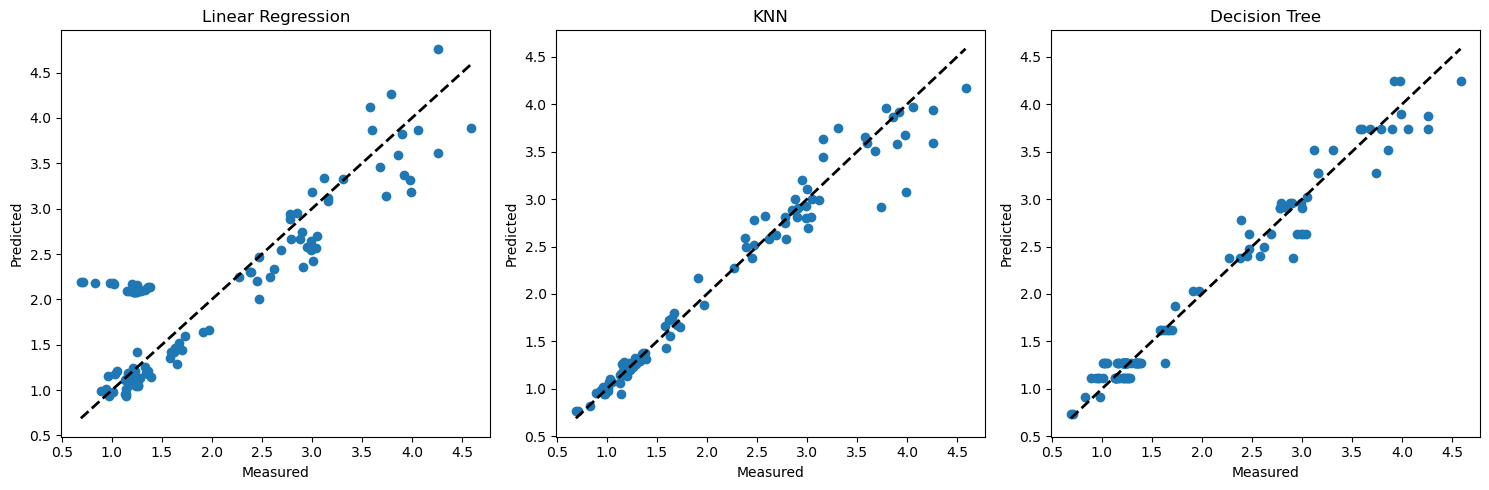

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Linear Regression
axes[0].scatter(y_test, lr_y_pred)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[0].set_xlabel('Measured')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Linear Regression')

# KNN
axes[1].scatter(y_test, knn_y_pred)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[1].set_xlabel('Measured')
axes[1].set_ylabel('Predicted')
axes[1].set_title('KNN')

# Decision Tree
axes[2].scatter(y_test, dt_y_pred)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[2].set_xlabel('Measured')
axes[2].set_ylabel('Predicted')
axes[2].set_title('Decision Tree')

plt.tight_layout()
plt.show()